In [11]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import cv2
import PIL.Image
import os
from tkinter import *
import pyodbc
from tkinter import font
import datetime
import csv

In [12]:
driver= '{SQL Server Native Client 11.0}'

cn = pyodbc.connect(
    Trusted_Connection='Yes',
    Driver='{SQL Server Native Client 11.0}',
    Server='.',
    Database='SAS'
)

cursor = cn.cursor()

In [21]:
window = tk.Tk()
window.title("Student attendance system")
window.configure(bg='#213555')
bold = font.Font(weight="bold", size=14)

button_font = ("INTER", 10)
label_font = ("INTER", 15)
custom_font = ("KOULEN", 22)
text_label = tk.Label(window, text="SISTEMI PËR RUAJTJE TË PREZENCËS SË STUDENTËVE", font=custom_font, bg='#213555', fg='#F0F0F0')
text_label.pack(pady=50)

l1 = tk.Label(window, text="Emri", font=label_font, bg='#213555', fg='#F0F0F0')
l1.pack(pady=5, padx=204, anchor="nw")
f1 = tk.Entry(window, width=28, relief=tk.RIDGE, font=('Arial',28), bg='#F0F0F0')
f1.pack()

l2 = tk.Label(window, text="Mbiemri", font=label_font, bg='#213555', fg='#F0F0F0')
l2.pack(pady=5, padx=204, anchor="nw")
f2 = tk.Entry(window,width=28, relief=tk.RIDGE, font=('Arial',28), bg='#F0F0F0')
f2.pack()

l3 = tk.Label(window, text="Mosha", font=label_font, bg='#213555', fg='#F0F0F0')
l3.pack(pady=5, padx=204, anchor="nw")
f3 = tk.Entry(window,width=28, relief=tk.RIDGE, font=('Arial',28), bg='#F0F0F0')
f3.pack()

# funksioni i parë që përdoret për gjenerimin e datasetit dhe regjistrimin e studentëve
def generate_dataset():
    if f1.get()=="" or f2.get()=="" or f3.get()=="":
        messagebox.showinfo("Result","Ju lutem plotësoni të gjitha hapsirat e zbrazëta!")
    else:
        sql = "INSERT INTO students(name,lastname,age) values(?,?,?)"
        val = (f1.get(),f2.get(),f3.get())
        cursor.execute(sql,val)
        cn.commit()
        print(cursor.rowcount, "record inserted")
        # Cascade classifier
        face_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
        # convert image in grayscale image from rgb
        def face_cropped(img):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_classifier.detectMultiScale(gray,1.2,5)
    
            if faces is ():
                return None
            for(x,y,w,h) in faces:
                cropped_face=img[y:y+h,x:x+w]
            return cropped_face 
        camera = cv2.VideoCapture(0)

        cursor.execute('SELECT MAX(id) from students')
        result = cursor.fetchone()
        #id=1
        img_id=0
    
        while True:
            ret,frame = camera.read()
            if face_cropped(frame) is not None:
                img_id+=1
                face = cv2.resize(face_cropped(frame),(300,300))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                file_path = "Data/user."+str(result[0]) +"."+str(img_id)+".jpg"
                cv2.imwrite(file_path,face)
                cv2.putText(face,str(img_id),(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
                cv2.imshow("Cropped face", face)
                if cv2.waitKey(1)==13 or int(img_id)==200:
                    break
        camera.release()
        cv2.destroyAllWindows()
        messagebox.showinfo('Result','Dataseti u gjenerua me sukses!')

# funksioni i dytë përdoret për trajnimin e modelit
def train_classifier():
    data_dir="C:/Users/fitor/OneDrive/Desktop/Tema e diplomes/StudentAttendanceSystem-face_recognition/Data"
    path = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
     
    faces = []
    ids = []
     
    for image in path:
        img = PIL.Image.open(image).convert('L')
        imageNp = np.array(img, 'uint8')
        id = int(os.path.split(image)[1].split(".")[1])
         
        faces.append(imageNp)
        ids.append(id)
         
    ids = np.array(ids)
     
    # Train and save classifier
    clf = cv2.face.LBPHFaceRecognizer_create()
    clf.train(faces,ids)
    clf.write("classifier.xml")
    messagebox.showinfo('Result','Classifier është trajnuar me sukses!')

# funksion ndihmes per te rekorduar prezencen e studenteve ne Excel sheet
def getAttendance(emri,mbiemri):
    with open('Student_Attendance.csv','r+') as f:
        myList = f.readlines()
        nameList = []
        dateList = []
        for line in myList:
            entry = line.split(',')
            nameList.append(entry[0])
            dateList.append(entry[3])
        now = datetime.datetime.now()
        today = now.date()
        if emri not in nameList and today not in dateList:
            dateString = now.strftime('%H:%M:%S')
            f.writelines(f'\n{emri},{mbiemri},{dateString},{today}')

def testAccuracy(pred,emri,mbiemri):
    with open('EvaluateModel.csv','r+') as f:
        myList = f.readlines()
        #for i in range(len(preds)):
        f.writelines(f'\n{emri},{mbiemri},{pred}')


# funksioni i tretë përdoret për detektimin dhe njohjen e fytyrës duke përdor klasifikuesin e trajnuar nga ne dhe klasifikuesin haar të gatshëm të OpenCV
def detect_face():
    #preds = []
    #names = []
    def draw_boundary(img, classifier, scaleFactor, minNeighbors, color, text, clf):
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    
        coordinates = []
        
        for (x,y,w,h) in features:
            cv2.rectangle(img, (x,y), (x+w,y+h), color, 2 )
            id, pred = clf.predict(gray_img[y:y+h,x:x+w])

            cursor.execute("select name,lastname from students where id="+str(id))
            result = cursor.fetchone()
            name, lastname = result
            s = f"{name} {lastname}"
            s=''+''.join(s)
            
            if pred<40:
                cv2.putText(img, s, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)
                testAccuracy(pred,name,lastname)
                getAttendance(name, lastname)
            else:
                cv2.putText(img, "UNKNOWN", (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 1, cv2.LINE_AA)
                testAccuracy(pred,"UNKNOWN","UNKNOWN")
            coordinates = [x,y,w,h]
        return coordinates

    def recognize(img,clf,faceCascade):
        coordinates = draw_boundary(img,faceCascade,1.1,10,(255,255,255),"Face",clf)
        return img
    
    # loading classifier
    faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
     
    clf = cv2.face.LBPHFaceRecognizer_create()
    clf.read("classifier.xml")
     
    video_capture = cv2.VideoCapture(0)
    while True:
        ret, img = video_capture.read()
        img = recognize(img, clf, faceCascade)
        cv2.imshow("Face Detection", img)
        if cv2.waitKey(1)==13:
            break
    video_capture.release()
    cv2.destroyAllWindows()
    
b2 = tk.Button(window, text="Regjistrohu", bg='#09ba94',fg='#F0F0F0', width=16, height=2, relief=tk.RIDGE, bd=0, font=bold, command=generate_dataset)
b2.place(x=100, y=440)

b3 = tk.Button(window, text="Train model", bg='#09ba94',fg='#F0F0F0', width=16, height=2, relief=tk.RIDGE, bd=0, font=bold, command=train_classifier)
b3.place(x=400, y=440)

b4 = tk.Button(window, text="Ruaj prezencën", bg='#09ba94',fg='#F0F0F0', width=16, height=2, relief=tk.RIDGE, bd=0, font=bold, command=detect_face)
b4.place(x=700,y=440)

window.geometry("1000x600")
window.mainloop()

<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\fitor\AppData\Local\Temp\ipykernel_14184\1382171046.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


Confusion Matrix

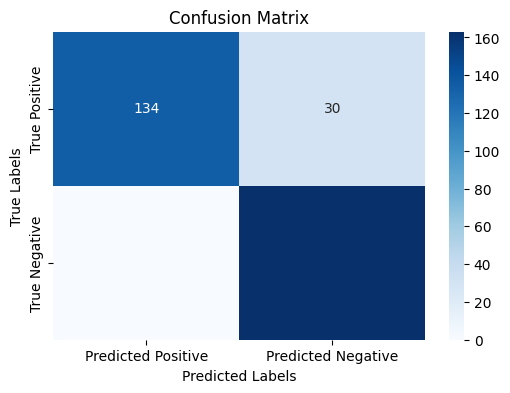

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('EvaluateModel.csv')
TP = sum((data['Prediction'] == '+') & (data['TrueLabels'] == '+'))
FP = sum((data['Prediction'] == '+') & (data['TrueLabels'] == '-'))
TN = sum((data['Prediction'] == '-') & (data['TrueLabels'] == '-'))
FN = sum((data['Prediction'] == '-') & (data['TrueLabels'] == '+'))

confusion_matrix = pd.DataFrame({'Predicted Positive': [TP, FP], 'Predicted Negative': [FN, TN]}, index=['True Positive', 'True Negative'])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy score calculation

In [27]:
from sklearn.metrics import accuracy_score

true_labels = data['TrueLabels'] 
predicted_labels = data['Prediction']

accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy score:", accuracy)
print("Accuracy percentage:",accuracy*100,"%")

Accuracy score: 0.908256880733945
Accuracy percentage: 90.82568807339449 %
